In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
## Loading the dataset
path='/content/drive/My Drive/Company Stock and Investment.csv'
df=pd.read_csv(path)

In [9]:
df.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [10]:
df=df.drop(['Comp Stock','Oil Investments','Other sharesInvestments'],axis=1)
df

,Date,Gold Investments
0,31-12-2009,0.000150
1,04-01-2010,0.001097
2,05-01-2010,0.001560
3,06-01-2010,0.006009
4,07-01-2010,0.000221
...,...,...
1979,09-11-2017,0.000623
1980,10-11-2017,-0.000389
1981,13-11-2017,-0.004944
1982,14-11-2017,-0.002621


In [11]:
df['Date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.set_index('Date', inplace=True)

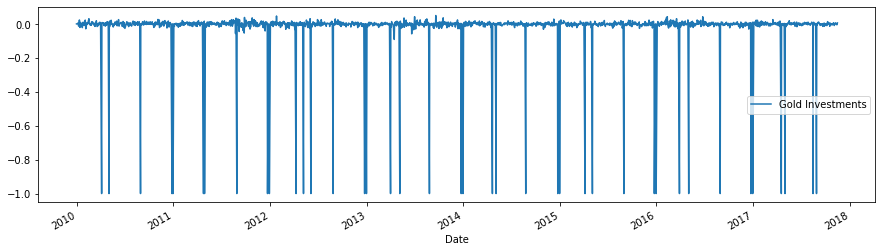

In [12]:
df.plot(figsize=(15,4))

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [15]:
print(df)

[[0.95290706]
 [0.95380958]
 [0.95425126]
 ...
 [0.94805377]
 [0.95026699]
 [0.95844556]]


In [16]:
##splitting dataset into train and test split
training_size=int(len(df)*0.76)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [17]:
training_size,test_size

(1507, 477)

In [18]:
train_data

array([[0.95290706],
       [0.95380958],
       [0.95425126],
       ...,
       [0.94936419],
       [0.94687016],
       [0.        ]])

In [21]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----29 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
print(X_train.shape), print(y_train.shape)

(1476, 30)
(1476,)


(None, None)

In [29]:
print(X_test.shape), print(ytest.shape)

(446, 30)
(446,)


(None, None)

In [30]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [32]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
24/24 [==============================] - 0s 11ms/step - loss: 0.0176 - val_loss: 0.0194
Epoch 2/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 3/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 4/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0177 - val_loss: 0.0180
Epoch 5/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0177 - val_loss: 0.0202
Epoch 6/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0192 - val_loss: 0.0181
Epoch 7/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0181 - val_loss: 0.0192
Epoch 8/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0181 - val_loss: 0.0181
Epoch 9/200
24/24 [==============================] - 0s 10ms/step - loss: 0.0178 - val_loss: 0.0181
Epoch 10/200
24/24 [==============================] - 0s 9ms/step - loss: 0.0177 - val_loss: 0.0190
Epoch 

In [36]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [38]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [40]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
mse = mean_squared_error(ytest,test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(ytest,test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(ytest,test_predict))
print('RMSE: '+str(rmse))

MSE: 0.8987487119225994
MAE: 0.9384463369269783
RMSE: 0.948023581944352


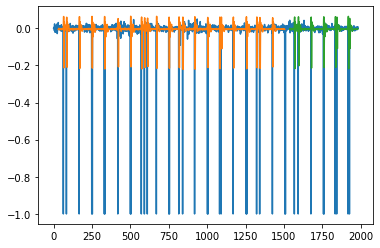

In [44]:
### Plotting 
# shift train predictions for plotting
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [45]:
len(test_data)

477

In [47]:
x_input=test_data[447:].reshape(1,-1)
x_input.shape

(1, 30)

In [48]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [49]:
temp_input

[0.9529514820427967,
 0.9432705500110078,
 0.9655632236037189,
 0.9621897529928163,
 0.9511783357559975,
 0.9535035624171608,
 0.9596689142407934,
 0.955477104625652,
 0.9392037612080554,
 0.9493902968064337,
 0.9573787874258493,
 0.9489132056719277,
 0.9480795595523427,
 0.9539229093502605,
 0.9516822500710305,
 0.9518304726056713,
 0.9473041578355554,
 0.9569398830947219,
 0.9513788517260237,
 0.9579403811542987,
 0.9543685992705512,
 0.9438268015885953,
 0.9555464592159298,
 0.956288037791002,
 0.9590386395266067,
 0.9533581781681303,
 0.9523937717826748,
 0.9480537748851812,
 0.9502669916869234,
 0.9584455616934257]

In [50]:
# demonstrate prediction for next 2 years
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<775):
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9485341]
31
1 day input [0.94327055 0.96556322 0.96218975 0.95117834 0.95350356 0.95966891
 0.9554771  0.93920376 0.9493903  0.95737879 0.94891321 0.94807956
 0.95392291 0.95168225 0.95183047 0.94730416 0.95693988 0.95137885
 0.95794038 0.9543686  0.9438268  0.95554646 0.95628804 0.95903864
 0.95335818 0.95239377 0.94805377 0.95026699 0.95844556 0.94853407]
1 day output [[0.947537]]
2 day input [0.96556322 0.96218975 0.95117834 0.95350356 0.95966891 0.9554771
 0.93920376 0.9493903  0.95737879 0.94891321 0.94807956 0.95392291
 0.95168225 0.95183047 0.94730416 0.95693988 0.95137885 0.95794038
 0.9543686  0.9438268  0.95554646 0.95628804 0.95903864 0.95335818
 0.95239377 0.94805377 0.95026699 0.95844556 0.94853407 0.947537  ]
2 day output [[0.947637]]
3 day input [0.96218975 0.95117834 0.95350356 0.95966891 0.9554771  0.93920376
 0.9493903  0.95737879 0.94891321 0.94807956 0.95392291 0.95168225
 0.95183047 0.94730416 0.95693988 0.95137885 0.95794038 0.9543686
 0.9438268  0.95554646 0.9

In [51]:
day_new=np.arange(1,30)
day_pred=np.arange(31,806)

In [52]:
len(df)

1984

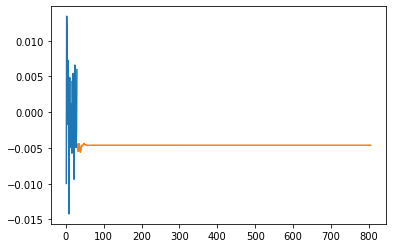

In [56]:
plt.plot(day_new,scaler.inverse_transform(df[1955:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

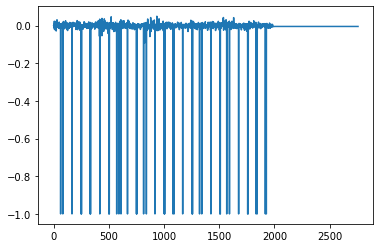

In [61]:
df3=df.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)
